In [37]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
import sklearn as sk

[*********************100%***********************]  1 of 1 completed

Coefficient: -0.002388662527327194
Intercept: 0.17970979659972525
R-Squared: 0.0010381374975938495


Price,Close,High,Low,Open,Volume,Close + 1,Target,RSI,Predictions,Residuals
13,24.156851,24.452507,23.826412,24.452507,378100,24.243813,0.359988,41.747223,0.079990,-0.279998
14,24.243813,24.243813,24.122072,24.156855,34900,24.330780,0.358720,44.444174,0.073548,-0.285173
15,24.330780,24.365563,24.243822,24.313388,513600,24.313395,-0.071455,41.748526,0.079987,0.151441
16,24.313395,24.417744,24.191654,24.400352,373700,24.626415,1.287441,39.604480,0.085108,-1.202333
17,24.626415,24.626415,24.330759,24.330759,26300,24.678610,0.211946,41.345770,0.080949,-0.130997
...,...,...,...,...,...,...,...,...,...,...
8136,591.150024,591.309998,578.429993,586.070007,72588500,587.729980,-0.578541,74.608258,0.001496,0.580037
8137,587.729980,592.770020,586.989990,591.559998,68445500,590.049988,0.394740,69.895162,0.012754,-0.381986
8138,590.049988,593.200012,586.070007,593.059998,69973300,589.390015,-0.111850,69.161140,0.014507,0.126358
8139,589.390015,591.130005,583.239990,588.929993,90601200,592.710022,0.563295,69.224831,0.014355,-0.548940


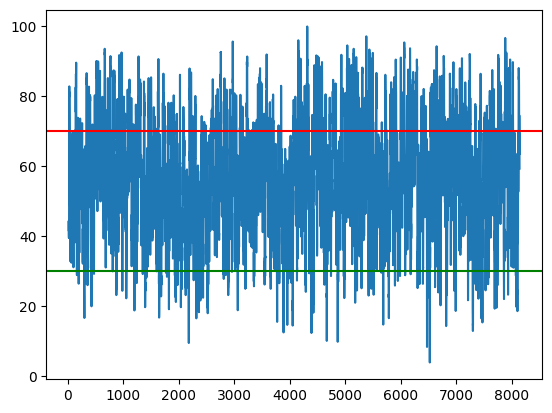

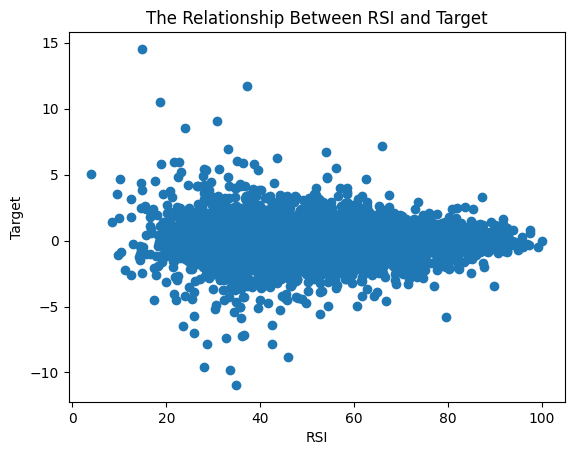

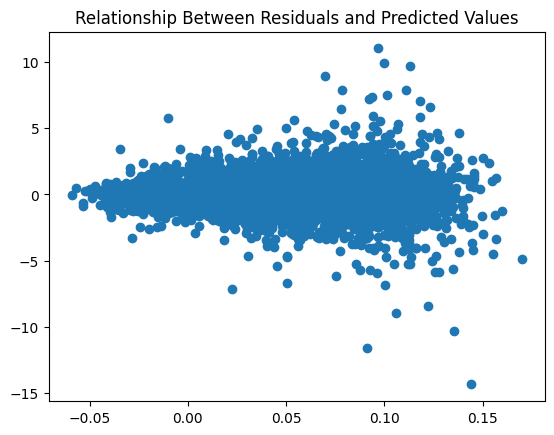

In [ ]:
TICKER = 'SPY'
INTERVAL='1d'

# set period based on interval
if INTERVAL == '1h':
    PERIOD = '730d'
else:
    PERIOD = 'max'

SHIFT = 1
STRATEGY = 'RSI'
RSI_LENGTH = 14
OVERBOUGHT = 70
OVERSOLD = 30

# what subsetion of that data are you interested in
LOOKBACK = 10000

def get_data(ticker=TICKER, lookback=LOOKBACK, interval=INTERVAL):

    # get data at interval you want
    df = yf.download(ticker, interval=interval, period=PERIOD)
    df.columns = df.columns.get_level_values(0)

    # reset the index to make plots prettier
    df = df.reset_index(drop=True)

    # only return the subset of data you are interested in
    return df.iloc[-lookback:, :]

# define the target variable (also called dependent variable, or y)
def add_target(df, shift=SHIFT):

    # what is the close price SHIFT days from now?
    df[f'Close + {shift}'] = df['Close'].shift(-shift)

    # what is the change in close price SHIFT days from now?
    df['Target'] = (df[f'Close + {shift}'] - df['Close']) / df['Close'] * 100

    return df

def add_RSI(df, length=RSI_LENGTH):

    price_change = df['Close'].diff()
    
    # separate gains/losses
    gain = price_change.where(price_change > 0, 0)
    loss = -price_change.where(price_change < 0, 0)

    # average gain vs loss
    avg_gain = gain.rolling(window=length).mean()
    avg_loss = loss.rolling(window=length).mean()

    # calculate rsi
    rs = avg_gain / avg_loss
    rsi = 100 - (100 / (1 + rs))
    df['RSI'] = rsi

    # plot the relative strength index
    plt.plot(df['RSI'])
    plt.axhline(OVERBOUGHT, color='red')
    plt.axhline(OVERSOLD, color='green')

    return df.dropna()

def generate_regression_output(df, features='RSI', target='Target'):

    subset = df[[features, target]].dropna()

    # reshape for sklearn
    X = subset[[features]].values # 2d
    y = subset[target].values # 1d

    model = sk.linear_model.LinearRegression()
    model.fit(X, y)

    # use the regression model to "predict" the target variable
    y_pred = model.predict(X)

    # what is the relationship between features and target?
    r2 = sk.metrics.r2_score(y, y_pred)

    # make coefficient variable
    coefficient = model.coef_[0]
    intercept = model.intercept_

    # coef, intercept, r2... mse later on
    print(f"Coefficient: {coefficient}")
    print(f"Intercept: {intercept}")
    print(f"R-Squared: {r2}")

    # plot a relationship between feature and target
    plt.figure()
    plt.title(f'The Relationship Between {features} and {target}')
    plt.scatter(X, y)
    plt.xlabel(f"{features}")
    plt.ylabel(f"{target}")

    return coefficient, intercept

def test_linearity(df, coef, intercept):

    # information necessary
    df['Predictions'] = coef * df[f'{STRATEGY}'] + intercept
    df['Residuals'] = df['Predictions'] - df['Target']

    # plot relationship
    plt.figure()
    plt.scatter(df['Predictions'], df['Residuals'])
    plt.title('Relationship Between Residuals and Predicted Values')

    return df

def main():
    df = get_data()
    df = add_target(df)
    df = add_RSI(df)
    fit_coef, fit_intercept = generate_regression_output(df)
    df = test_linearity(df, coef=fit_coef, intercept=fit_intercept)

    return df

df = main()
df